<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/Phone_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 경로 설정
BASE_PATH = '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/UCI HAR Dataset'

def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

def load_group(filenames, prefix=''):
    loaded = []
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    return np.dstack(loaded)   # (samples, timesteps, features)

def load_dataset_group(group, prefix=''):
    filepath = prefix + '/' + group + '/Inertial Signals/'
    filenames = []
    # 9개 센서
    filenames += [f'total_acc_x_{group}.txt', f'total_acc_y_{group}.txt', f'total_acc_z_{group}.txt']
    filenames += [f'body_acc_x_{group}.txt',  f'body_acc_y_{group}.txt',  f'body_acc_z_{group}.txt']
    filenames += [f'body_gyro_x_{group}.txt', f'body_gyro_y_{group}.txt', f'body_gyro_z_{group}.txt']

    X = load_group(filenames, filepath)
    y = load_file(prefix + '/' + group + f'/y_{group}.txt')
    return X, y

def load_dataset(prefix=BASE_PATH):
    trainX, trainy = load_dataset_group('train', prefix)
    testX,  testy  = load_dataset_group('test',  prefix)

    # 1~6 → 0~5
    trainy = trainy - 1
    testy  = testy - 1

    trainy_oh = to_categorical(trainy)
    testy_oh  = to_categorical(testy)

    print('trainX:', trainX.shape,
          'trainy:', trainy.shape,
          'testX:', testX.shape,
          'testy:', testy.shape)

    return trainX, trainy, trainy_oh, testX, testy, testy_oh

# 데이터 불러오기
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-2560794805.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2560794805.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2560794805.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2560794805.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-25607

trainX: (7352, 128, 9) trainy: (7352, 1) testX: (2947, 128, 9) testy: (2947, 1)


In [ ]:
# 2. train/val 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    trainX, trainy_one_hot,
    test_size=0.2,
    random_state=100,
    stratify=trainy_one_hot
)

print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

# 입력 차원
n_timesteps = X_train.shape[1]   # 128
n_features  = X_train.shape[2]   # 9
n_outputs   = y_train.shape[1]   # 6

(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6)


In [ ]:
# 3. CNN + LSTM 모델
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

model = Sequential()
# (1) CNN으로 짧은 패턴 뽑기
model.add(Conv1D(filters=64,
                 kernel_size=3,
                 activation='relu',
                 input_shape=(n_timesteps, n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))   # 128 -> 64
model.add(Dropout(0.5))

# (2) LSTM으로 시퀀스 흐름 읽기
model.add(LSTM(100))
model.add(Dropout(0.5))

# (3) 분류기
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 124, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 62, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 90,850 (354.88 KB)

 Trainable params: 90,850 (354.88 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. 학습
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5345 - loss: 1.0604 - val_accuracy: 0.7322 - val_loss: 0.5468
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7641 - loss: 0.5038 - val_accuracy: 0.7811 - val_loss: 0.4197
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8535 - loss: 0.3662 - val_accuracy: 0.9266 - val_loss: 0.2143
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9206 - loss: 0.2100 - val_accuracy: 0.9320 - val_loss: 0.1673
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9417 - loss: 0.1622 - val_accuracy: 0.9409 - val_loss: 0.1585
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9404 - loss: 0.1790 - val_accuracy: 0.9429 - val_loss: 0.1335
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9451 - loss: 0.1289 - val_accuracy: 0.9490 - val_loss: 0.1199
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9139 - loss: 0.2175 - val_accuracy:

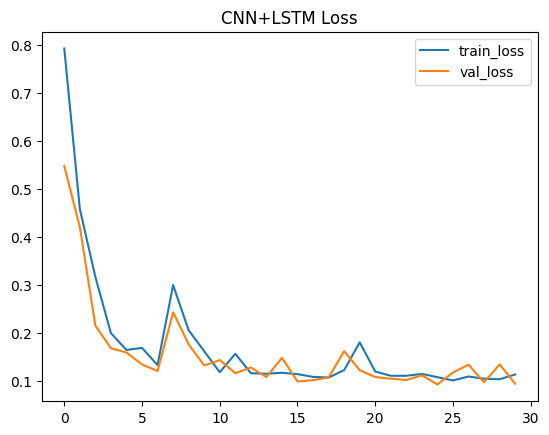

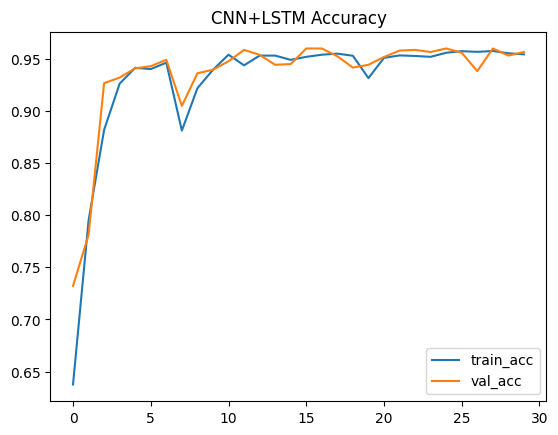

In [ ]:
# 5. 학습 곡선
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('CNN+LSTM Loss')
plt.show()

plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('CNN+LSTM Accuracy')
plt.show()

93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
CNN+LSTM test accuracy: 0.8958262639972854
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       496
           1       0.89      0.93      0.91       471
           2       0.90      0.95      0.93       420
           3       0.82      0.76      0.79       491
           4       0.83      0.84      0.83       532
           5       1.00      0.95      0.97       537

    accuracy                           0.90      2947
   macro avg       0.90      0.90      0.90      2947
weighted avg       0.90      0.90      0.90      2947



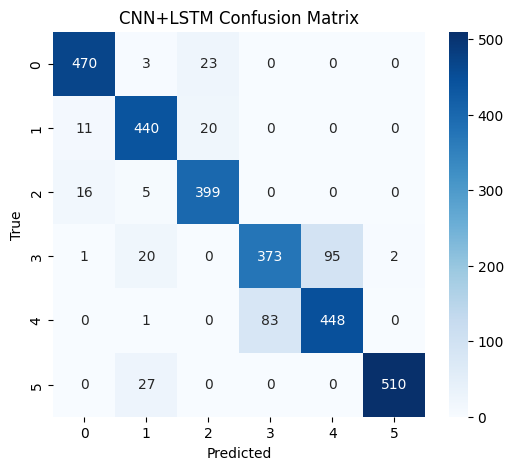

In [ ]:
# 6. 테스트셋 평가
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

y_pred_prob = model.predict(testX)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = testy.ravel()

print("CNN+LSTM test accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("CNN+LSTM Confusion Matrix")
plt.show()